# Downside Measures: 
## SemiDeviation, VaR and CVaR


We're going to look at a few measures of downside risk. We've already seen how to compute drawdowns, but we're going to look at 3 popular measures.

The first measure is the simplest, which is the semideviation, it's nothing more than the volatility of the subset of returns that are negative. It's an alternative measurement to standard deviation or variance and a method of measuring the below-mean fluctuations in the returns on investment. Semi-deviation will reveal the worst-case performance to be expected from a risky investment. 

The second measure is Value at risk (VaR) is a statistic that measures and quantifies the level of financial risk within a firm, portfolio or position over a specific time frame. This metric is most commonly used by investment and commercial banks to determine the extent and occurrence ratio of potential losses in their institutional portfolios. Risk managers use VaR to measure and control the level of risk exposure. One can apply VaR calculations to specific positions or whole portfolios or to measure firm-wide risk exposure.

The third measure of downside risk is Conditional Value at Risk (CVaR), also known as the expected shortfall, is a risk assessment measure that quantifies the amount of tail risk an investment portfolio has. CVaR is derived by taking a weighted average of the “extreme” losses in the tail of the distribution of possible returns, beyond the value at risk (VaR) cutoff point. It's used in portfolio optimization for effective risk management.

In [170]:
import pandas as pd
import numpy  as np
from scipy.stats import norm
from scipy.stats import skew
from scipy.stats import kurtosis
%matplotlib inline

First we will import the data from github

In [3]:
def get_hfi_returns():
    """
    Load and format the GSF Hedge Fund Index Returns
    """
    gsf_hedgefundindices = 'https://raw.githubusercontent.com/safarini/GSF/master/001_gsf_hedgefundindices.csv'
    hfi = pd.read_csv(gsf_hedgefundindices, header=0, index_col=0, parse_dates=True)
    hfi = hfi/100
    hfi.index = hfi.index.to_period('M')
    return hfi

In [11]:
# Assign the data to hfi
hfi = get_hfi_returns()

In [12]:
# Display the first 2 rows of hfi
hfi.head(2)

,Convertible Arbitrage,CTA Global,Distressed Securities,Emerging Markets,Equity Market Neutral,Event Driven,Fixed Income Arbitrage,Global Macro,Long/Short Equity,Merger Arbitrage,Relative Value,Short Selling,Funds Of Funds
date,,,,,,,,,,,,,
1997-01,0.0119,0.0393,0.0178,0.0791,0.0189,0.0213,0.0191,0.0573,0.0281,0.0150,0.0180,-0.0166,0.0317
1997-02,0.0123,0.0298,0.0122,0.0525,0.0101,0.0084,0.0122,0.0175,-0.0006,0.0034,0.0118,0.0426,0.0106


## SemiDeviation

In [15]:
# let's start by computing the standard deviation for all funds
hfi.std(ddof=0)

Convertible Arbitrage     0.016536
CTA Global                0.023290
Distressed Securities     0.017009
Emerging Markets          0.032476
Equity Market Neutral     0.008115
Event Driven              0.016712
Fixed Income Arbitrage    0.011517
Global Macro              0.014694
Long/Short Equity         0.019897
Merger Arbitrage          0.009600
Relative Value            0.011462
Short Selling             0.047655
Funds Of Funds            0.015536
dtype: float64

Since standard deviation takes into consideration both the upside and the downside. Therefore, we will adjust the code to so it will only capture the downside.

In [18]:
hfi[hfi<0].std(ddof=0)

Convertible Arbitrage     0.019540
CTA Global                0.012443
Distressed Securities     0.015185
Emerging Markets          0.028039
Equity Market Neutral     0.009566
Event Driven              0.015429
Fixed Income Arbitrage    0.017763
Global Macro              0.006579
Long/Short Equity         0.014051
Merger Arbitrage          0.008875
Relative Value            0.012244
Short Selling             0.027283
Funds Of Funds            0.012122
dtype: float64

We can create a function for semideviation as well

In [19]:
def semideviation(r):
    """
    Returns the semideviation aka negative semideviation of r
    r must be a Series or a DataFrame, else raises a TypeError
    """
    is_negative = r < 0
    return r[is_negative].std(ddof=0)

In [20]:
semideviation(hfi)

Convertible Arbitrage     0.019540
CTA Global                0.012443
Distressed Securities     0.015185
Emerging Markets          0.028039
Equity Market Neutral     0.009566
Event Driven              0.015429
Fixed Income Arbitrage    0.017763
Global Macro              0.006579
Long/Short Equity         0.014051
Merger Arbitrage          0.008875
Relative Value            0.012244
Short Selling             0.027283
Funds Of Funds            0.012122
dtype: float64

In [22]:
# Sort the values from smallest to largest 
semideviation(hfi).sort_values()

Global Macro              0.006579
Merger Arbitrage          0.008875
Equity Market Neutral     0.009566
Funds Of Funds            0.012122
Relative Value            0.012244
CTA Global                0.012443
Long/Short Equity         0.014051
Distressed Securities     0.015185
Event Driven              0.015429
Fixed Income Arbitrage    0.017763
Convertible Arbitrage     0.019540
Short Selling             0.027283
Emerging Markets          0.028039
dtype: float64

We can also apply this on another dataset

In [28]:
def get_ffme_returns():
    """
    Load the Fama-French Dataset for the returns of the Top and Bottom Deciles by MarketCap
    """ 
    gsf_portfolio = 'https://raw.githubusercontent.com/safarini/GSF/master/002_Portfolios_Formed_on_ME_monthly_EW.csv'
    me_m = pd.read_csv(gsf_portfolio, header=0, index_col=0, na_values=-99.99)
    rets = me_m[['Stock_02', 'Stock_04','Stock_06']]
    rets.columns = ['SmallCap', 'MidCap', 'LargeCap']
    rets = rets/100
    rets.index = pd.to_datetime(rets.index, format="%Y%m").to_period('M')
    return rets

In [29]:
ffme = get_ffme_returns()
semideviation(ffme)

SmallCap    0.052313
MidCap      0.042677
LargeCap    0.051307
dtype: float64

# VaR and CVaR

We'll look at three different ways to compute Value At Risk

1. Historic VaR
2. Parametric Gaussian VaR
3. Modified (Cornish-Fisher) VaR

To compute the historic VaR at a certain level, say 5%, all we have to do is to find the number such that 5% of the returns fall below that number and 95% of the returns fall above that number. In other words, we want the 5 percentile return.

Fortunately, numpy has a `np.percentile` function that computes exactly that.

The documentation says you give it an array and then you give it q, which is the q-th percentile of the data along the specified access, q should be a number between zero and 100. And we want to run it on just the columns which means axis is equal to zero.

Reporting: The idea is that there's a 5% percent chance you're going to lose this amount or more. So you generally try and report these as positive numbers rather than negative numbers, so I'm just going to make one-liner fix here, and I'm going to return negative of that. 

In [86]:
-np.percentile(hfi, 5, axis = 0)

array([0.01576, 0.03169, 0.01966, 0.04247, 0.00814, 0.02535, 0.00787,
       0.01499, 0.02598, 0.01047, 0.01174, 0.06783, 0.02047])

We can also use a function using for loop to arrive at the same result. 

In [84]:
# 5 is the level
def var_historic_0(r, level=5):
    for i in r.columns:
        print(-round(np.percentile(r[i], level),5))

In [85]:
var_historic_0(hfi)

0.01576
0.03169
0.01966
0.04247
0.00814
0.02535
0.00787
0.01499
0.02598
0.01047
0.01174
0.06783
0.02047


The way I'd interpret that is that in the first column, convertible arbitrage, there's a five percent chance that in any given month, you're going to lose about 1.5 percent or worse. 

We can also develop another function without using for loop, however before we jump into the function lets get yourself familiar with the .isinstance() and .aggregate() functions.

In [41]:
# if isinstance(r, pd.DataFrame): means if r is a DataFrame then rerun True otherwise return False
# if isinstance(r, pd.Series   ): means if r is a Series then rerun True otherwise return False
print(isinstance(hfi, pd.DataFrame))
print(isinstance(hfi, pd.Series))

True
False


.aggregate() function, allow you to apply the function over all the columns of the DataFrame, therefore it will be applied on all the series

In [82]:
def var_historic(r, level=5):
    """
    Returns the historic Value at Risk at a specified level
    i.e. returns the number such that "level" percent of the returns
    fall below that number, and the (100-level) percent are above
    """
    # if isinstance(r, pd.DataFrame): means if r is a DataFrame then rerun True otherwise return False
    if isinstance(r, pd.DataFrame):
    # r.aggregate() now applied on all coumns (Series) of the Dataframe therefore when var_historic is called inside the function it will returen false and jump to the elif isinstance(r, pd.Series):
    # split all the columns, so now all the columns are series then call the var historical function on all the serieses (columns)
        return r.aggregate(var_historic, level=level)
    elif isinstance(r, pd.Series):
        return -np.percentile(r, level)
    else:
        raise TypeError("Expected r to be a Series or DataFrame")   

In [71]:
type(hfi)

pandas.core.frame.DataFrame

In [83]:
var_historic(hfi, level=5)

Convertible Arbitrage     0.01576
CTA Global                0.03169
Distressed Securities     0.01966
Emerging Markets          0.04247
Equity Market Neutral     0.00814
Event Driven              0.02535
Fixed Income Arbitrage    0.00787
Global Macro              0.01499
Long/Short Equity         0.02598
Merger Arbitrage          0.01047
Relative Value            0.01174
Short Selling             0.06783
Funds Of Funds            0.02047
dtype: float64

Note that for reporting purposes, it is common to invert the sign so we report a positive number to represent the _loss_ i.e. the amount that is at risk.

# Conditional VaR aka Beyond VaR

Now that we have the VaR, the CVaR is very easy. All we need is to find the mean of the numbers that fell below the VaR!

In [126]:
hfi.head()

,Convertible Arbitrage,CTA Global,Distressed Securities,Emerging Markets,Equity Market Neutral,Event Driven,Fixed Income Arbitrage,Global Macro,Long/Short Equity,Merger Arbitrage,Relative Value,Short Selling,Funds Of Funds
date,,,,,,,,,,,,,
1997-01,0.0119,0.0393,0.0178,0.0791,0.0189,0.0213,0.0191,0.0573,0.0281,0.0150,0.0180,-0.0166,0.0317
1997-02,0.0123,0.0298,0.0122,0.0525,0.0101,0.0084,0.0122,0.0175,-0.0006,0.0034,0.0118,0.0426,0.0106
1997-03,0.0078,-0.0021,-0.0012,-0.0120,0.0016,-0.0023,0.0109,-0.0119,-0.0084,0.0060,0.0010,0.0778,-0.0077
1997-04,0.0086,-0.0170,0.0030,0.0119,0.0119,-0.0005,0.0130,0.0172,0.0084,-0.0001,0.0122,-0.0129,0.0009
1997-05,0.0156,-0.0015,0.0233,0.0315,0.0189,0.0346,0.0118,0.0108,0.0394,0.0197,0.0173,-0.0737,0.0275


In [127]:
-var_historic(hfi)

Convertible Arbitrage    -0.01576
CTA Global               -0.03169
Distressed Securities    -0.01966
Emerging Markets         -0.04247
Equity Market Neutral    -0.00814
Event Driven             -0.02535
Fixed Income Arbitrage   -0.00787
Global Macro             -0.01499
Long/Short Equity        -0.02598
Merger Arbitrage         -0.01047
Relative Value           -0.01174
Short Selling            -0.06783
Funds Of Funds           -0.02047
dtype: float64

In [128]:
is_beyond = hfi <= -var_historic(hfi)
is_beyond.head()

,Convertible Arbitrage,CTA Global,Distressed Securities,Emerging Markets,Equity Market Neutral,Event Driven,Fixed Income Arbitrage,Global Macro,Long/Short Equity,Merger Arbitrage,Relative Value,Short Selling,Funds Of Funds
date,,,,,,,,,,,,,
1997-01,False,False,False,False,False,False,False,False,False,False,False,False,False
1997-02,False,False,False,False,False,False,False,False,False,False,False,False,False
1997-03,False,False,False,False,False,False,False,False,False,False,False,False,False
1997-04,False,False,False,False,False,False,False,False,False,False,False,False,False
1997-05,False,False,False,False,False,False,False,False,False,False,False,True,False


In [120]:
hfi[hfi <= -var_historic(hfi)].head()

,Convertible Arbitrage,CTA Global,Distressed Securities,Emerging Markets,Equity Market Neutral,Event Driven,Fixed Income Arbitrage,Global Macro,Long/Short Equity,Merger Arbitrage,Relative Value,Short Selling,Funds Of Funds
date,,,,,,,,,,,,,
1997-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.0737,NaN


In [129]:
-hfi[is_beyond].mean()

Convertible Arbitrage     0.036550
CTA Global                0.041264
Distressed Securities     0.036429
Emerging Markets          0.072364
Equity Market Neutral     0.016879
Event Driven              0.038336
Fixed Income Arbitrage    0.028257
Global Macro              0.020629
Long/Short Equity         0.041943
Merger Arbitrage          0.019143
Relative Value            0.024650
Short Selling             0.096821
Funds Of Funds            0.033207
dtype: float64

In [109]:
def cvar_historic(r, level=5):
    """
    Computes the Conditional VaR of Series or DataFrame
    """
    if isinstance(r, pd.Series):
        is_beyond = r <= -var_historic(r, level=level)
        return -r[is_beyond].mean()
    elif isinstance(r, pd.DataFrame):
        return r.aggregate(cvar_historic, level=level)
    else:
        raise TypeError("Expected r to be a Series or DataFrame")

In [130]:
cvar_historic(hfi, level=5)

Convertible Arbitrage     0.036550
CTA Global                0.041264
Distressed Securities     0.036429
Emerging Markets          0.072364
Equity Market Neutral     0.016879
Event Driven              0.038336
Fixed Income Arbitrage    0.028257
Global Macro              0.020629
Long/Short Equity         0.041943
Merger Arbitrage          0.019143
Relative Value            0.024650
Short Selling             0.096821
Funds Of Funds            0.033207
dtype: float64

In [131]:
cvar_historic(ffme)

SmallCap    0.160965
MidCap      0.128909
LargeCap    0.158491
dtype: float64

## Parametric Gaussian VaR

The parametric method VAR (also known as Variance/Covariance VAR) calculation is the most common form used in practice with hedge fund managers. This method is popular because the only variables you need to do the calculation are the mean and standard deviation of the portfolio. The biggest assumption that mangers using Parametric VAR are making is that the returns from their portfolios are normally distributed. This allows the manager to use the calculated standard deviation to compute a standard normal z score to determine his/her risk position with a degree of confidence right off of a standard normal table. This is an important assumption because it allows the manager to use the normal distribution as a proxy for what expected returns might look like. In practice, this assumption of return normality has proven to be extremely risky. Indeed, this was the biggest mistake that LTCM made it gravely underestimating their portfolio risks.

An example of a parametric VAR calculation is as follows:  
Standard Deviation ($ terms): $50,000  
Mean ($ terms): $35,000   
Z Score for 95% confidence: 1.65  
 
Calculated VAR for the period with 95% confidence is: 35,000 - 50,000 (1.65) = -$47,500  

The idea behind this is very simple. If a set of returns is normally distributed, we know, for instance, that 50% of the returns are below the mean and 50% are above. We also know that approx two thirds of the returns lie within 1 standard deviation. That means one third lie beyond one standard deviation from the mean. Since the normal distribution is symmetric, approximately one sixth (approx 16%) lie below one standard deviation away from the mean. Therefore, if we know the mean and standard deviation and if we assume that the returns are normally distributed, the 16% VaR would be the mean minus one standard deviation. In general we can always convert a percentile point to a z-score (which is the number of standard deviations away from the mean that a number is). Therefore, if we can convert the VaR level (such as 1% or 5%) to a z-score, we can calculate the return level where that percent of returns lie below it.

`scipy.stat.norm` contains a function `ppf()` which does exactly that. It takes the cumulative % or the percentile such as 0.05 or 0.01 and gives you the z-score corresponding to that in the normal distribution.

<img src = 'https://raw.githubusercontent.com/safarini/Pictures/master/The_Normal_Distributionv2.svg.png'>

In [145]:
# mean of zero has a Z score of zero
norm.ppf(.5)

0.0

In [153]:
# Percentile such as 0.05 has a Z score of -1.64
z = norm.ppf(.05)
z

-1.6448536269514729

Therefore, all we need to do to estimate the VaR using this method is to find the z-score corresponding to percentile level, and then add that many standard deviations to the mean, to obtain the VaR.

In [161]:
-(hfi.mean() + z*hfi.std(ddof=0))

Convertible Arbitrage     0.021691
CTA Global                0.034235
Distressed Securities     0.021032
Emerging Markets          0.047164
Equity Market Neutral     0.008850
Event Driven              0.021144
Fixed Income Arbitrage    0.014579
Global Macro              0.018766
Long/Short Equity         0.026397
Merger Arbitrage          0.010435
Relative Value            0.013061
Short Selling             0.080086
Funds Of Funds            0.021292
dtype: float64

In [159]:
def var_gaussian(r, level=5):
    """
    Returns the Parametric Gauusian VaR of a Series or DataFrame
    """
    # compute the Z score assuming it was Gaussian
    z = norm.ppf(level/100)
    return -(r.mean() + z*r.std(ddof=0))

In [160]:
var_gaussian(hfi)

Convertible Arbitrage     0.021691
CTA Global                0.034235
Distressed Securities     0.021032
Emerging Markets          0.047164
Equity Market Neutral     0.008850
Event Driven              0.021144
Fixed Income Arbitrage    0.014579
Global Macro              0.018766
Long/Short Equity         0.026397
Merger Arbitrage          0.010435
Relative Value            0.013061
Short Selling             0.080086
Funds Of Funds            0.021292
dtype: float64

In [139]:
var_historic(hfi)

Convertible Arbitrage     0.01576
CTA Global                0.03169
Distressed Securities     0.01966
Emerging Markets          0.04247
Equity Market Neutral     0.00814
Event Driven              0.02535
Fixed Income Arbitrage    0.00787
Global Macro              0.01499
Long/Short Equity         0.02598
Merger Arbitrage          0.01047
Relative Value            0.01174
Short Selling             0.06783
Funds Of Funds            0.02047
dtype: float64

# Cornish-Fisher Modification

The Cornish-Fisher modification is an elegant and simple adjustment.

The z-score tells us how many standard deviations away from the mean we need to go to find the VaR. If the returns arent normal, we know that z-score will give us an inaccurate number. The basic idea is that since we can observe the skewness and kurtosis of the data, we can adjust the z-score up or down to come up with a modifed z-score. e.g. intuitively, all other things being equal, if the skewness is negative, we'll decrease the z-score further down, and if the skewness is positive, we'll push it up.

The adjusted z-score which we'll call $z_{cornishfisher}$ given by:

$$ z_{cornishfisher} = z +\frac{1}{6}(z^2-1)S + \frac{1}{24}(z^3-3z)(K-3)-\frac{1}{36}(2z^3-5z)S^2 $$


We can modify the previous function by adding a "modified" parameter with a default value of `True` as follows. If `True` then the following piece of code is executed, which modifes `z`:

```python
    if modified:
        # modify the Z score based on observed skewness and kurtosis
        s = skewness(r)
        k = kurtosis(r)
        z = (z +
                (z**2 - 1)*s/6 +
                (z**3 -3*z)*(k-3)/24 -
                (2*z**3 - 5*z)*(s**2)/36
            )
```
We can now compare the different methods:

In [171]:
skew(hfi)

array([-2.63959223,  0.17369864, -1.30084204, -1.16706749, -2.12443538,
       -1.40915356, -3.94032029,  0.98292188, -0.39022677, -1.32008333,
       -1.81546975,  0.76797484, -0.36178308])

In [172]:
kurtosis(hfi)

array([20.28083446, -0.04703963,  4.88998336,  6.25078841, 14.21855526,
        5.03582817, 26.84219928,  2.74167945,  1.52389258,  5.73894979,
        9.12120787,  3.11777175,  4.07015278])

In [174]:
def var_gaussian(r, level=5, modified=False):
    """
    Returns the Parametric Gauusian VaR of a Series or DataFrame
    If "modified" is True, then the modified VaR is returned,
    using the Cornish-Fisher modification
    """
    # compute the Z score assuming it was Gaussian
    z = norm.ppf(level/100)
    if modified:
        # modify the Z score based on observed skewness and kurtosis
        s = skew(r)
        k = kurtosis(r)
        z = (z +
                (z**2 - 1)*s/6 +
                (z**3 -3*z)*(k-3)/24 -
                (2*z**3 - 5*z)*(s**2)/36
            )
        
    return -(r.mean() + z*r.std(ddof=0))

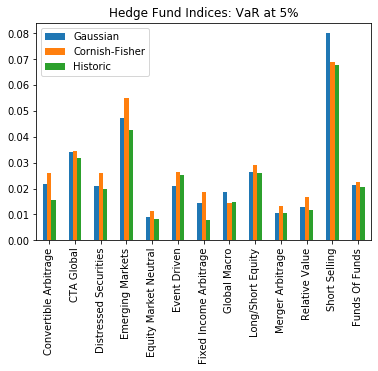

In [175]:
var_table = [var_gaussian(hfi), 
             var_gaussian(hfi, modified=True), 
             var_historic(hfi)]
comparison = pd.concat(var_table, axis=1)
comparison.columns=['Gaussian', 'Cornish-Fisher', 'Historic']
comparison.plot.bar(title="Hedge Fund Indices: VaR at 5%")

Note that in some cases, the cornish-fisher VaR is lower i.e. estimates a smaller loss than you would get from a pure gaussian assumption. That can happen if the observed skewness is positive, as is the case for "Short Selling" and "Global Macro"